Daniel Eftekhari
daniel.eftekhari@mail.utoronto.ca

In this mini-tutorial, we're going to predict whether a patient has breast cancer from a set of input features. First let's import the python packages that we'll need, as well as the dataset.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer

In supervised learning, we use input features to predict output class labels. That is, each input (x) consists of a number of features, and in binary classification, each output (y) is either 1 or 0.

In [2]:
dataset = load_breast_cancer()
# X is our input, Y is our target.
X, Y = dataset.data, dataset.target
# Display the dataset size.
print(X.shape, Y.shape)

(569, 30) (569,)


This is a relatively small dataset for machine learning applications: there are only 569 data points altogether, and 30 features. We'll start with a simple model in this tutorial: logistic regression. But first a few things...

In [3]:
# Make class 1 malignant, and class 0 benign.
Y = np.abs(Y - 1)
# Reshape Y into an (N x 1) matrix.
Y = np.reshape(Y, (Y.shape[0], 1))

In case there are regularities in the dataset, it's good practice to randomly shuffle your data, so that the model trained won't be biased.

In [4]:
# Set random seed for reproducibility
np.random.seed(1)
indices = np.random.permutation(len(X))
X, Y = X[indices], Y[indices]

Next, we split our data into training and test sets. We'll use a 80%/20% training/test split. In practice, it's important to use a validation set to determine your best model before evaluating on the test set, but we'll skip this detail for the sake of simplicity.

In [5]:
n = X.shape[0]

X_training = X[0:int(n*4/5.0)]
X_testing = X[int(n*4/5.0):]

Y_training = Y[0:int(n*4/5.0)]
Y_testing = Y[int(n*4/5.0):]

Let's examine the class distribution in our training data, as well as visualize which features seem at first glance to be most discriminative.

In [6]:
print('In the training set, class 0 (benign) has {} instances, and class 1 (malignant) has {} instances.'
      .format(np.sum(Y_training == 0), np.sum(Y_training == 1)))

In the training set, class 0 (benign) has 288 instances, and class 1 (malignant) has 167 instances.


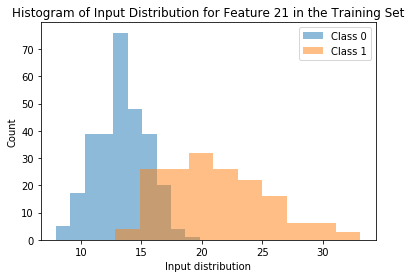

In [7]:
plt.hist(X_training[Y_training[:,0] == 0, 20], alpha=0.5, label='Class 0')
plt.hist(X_training[Y_training[:,0] == 1, 20], alpha=0.5, label='Class 1')
plt.legend()
plt.xlabel('Input distribution')
plt.ylabel('Count')
plt.title('Histogram of Input Distribution for Feature 21 in the Training Set')
plt.show()

It seems that higher values of the input (in the training set) for feature 21 is indicative of class 1 (malignant). Let's take a look at another feature.

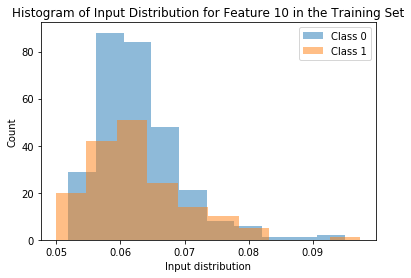

In [8]:
plt.hist(X_training[Y_training[:,0] == 0, 9], alpha=0.5, label='Class 0')
plt.hist(X_training[Y_training[:,0] == 1, 9], alpha=0.5, label='Class 1')
plt.legend()
plt.xlabel('Input distribution')
plt.ylabel('Count')
plt.title('Histogram of Input Distribution for Feature 10 in the Training Set')
plt.show()

It seems that higher values of the input for feature 10 is somewhat indicative of class 0 (benign). We'll come back to whether our logistic regression model learns these patterns we observed later in the tutorial!

Normalize each feature using the mean and standard deviation of the training set. This is important for numerical stability during optimization.

In [9]:
mean = np.mean(X_training, axis=0, keepdims=True)
std = np.std(X_training, axis=0, keepdims=True)
X_training = (X_training - mean) / std
X_testing = (X_testing - mean) / std

As we saw in the presentation, the sigmoid function is how we get outputs in the range of 0 to 1. Let's write a function that does just that.

In [10]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

Next, we initialize our parameters: the weights and the bias term. In logistic regression, initializing these to zero works fine, but in neural network architectures, carefully initializing the weights is critical to model performance.

In [11]:
def initialize_parameters(num_features):
    weights = np.zeros((1, num_features))
    bias = 0.0

    return weights, bias

Next, we'll write the function that implements forward propagation and backward propagation.

In [12]:
def forward_backward_prop(weights, bias, X, Y):
    n = X.shape[0]
    
    # Forward propagation
    predictions = sigmoid(np.dot(X, np.transpose(weights)) + bias)
    cost = (-1.0 / n) * np.sum(Y * np.log(predictions) + (1-Y) * np.log(1-predictions))
    
    # Backward propagation
    dz = (predictions - Y)
    dw = (1.0/n) * np.dot(np.transpose(dz), X)
    db = (1.0/n) * np.sum(dz)
        
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

Next, we optimize the weights and bias, and show how the training cost decreases as we train our model.

In [13]:
def optimize(weights, bias, X, Y, num_epochs, learning_rate):
    # For plotting.
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.ion()
    plt.suptitle('Cost vs. Training Iteration for Learning Rate {}'.format(learning_rate))
    fig.show()
    fig.canvas.draw()
    
    costs = []
    for i_iter in range(num_epochs):
        grads, cost = forward_backward_prop(weights, bias, X, Y)
        costs.append(cost)
        
        ax.clear()
        ax.plot(np.linspace(0, i_iter, i_iter+1), costs[0:i_iter+1], color='b')
        fig.canvas.draw()
        
        dw = grads["dw"]
        db = grads["db"]

        # Update parameters after each epoch
        weights = weights - learning_rate * dw
        bias = bias - learning_rate * db

    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.ylim(0.0, 1.0)
    plt.show()
    
    params = {"weights": weights,
              "bias": bias}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

Next, we'll write the function for making predictions. We'll use a threshold of 0.50 for predictions, but in practice this threshold can be tuned - which is a particularly important practice if there is a class imbalance in the dataset.

In [14]:
def predict(weights, bias, X, threshold=0.5):
    Y_predict = sigmoid(np.dot(X, np.transpose(weights)) + bias)
    Y_predict = (Y_predict > threshold)
    
    return Y_predict

Finally, we'll call the functions we wrote above to create the model.

In [15]:
def model(X_train, Y_train, X_test, Y_test, num_epochs=100, learning_rate=0.01):    
    m = X_train.shape[1]
    weights, bias = initialize_parameters(m)
    
    params, grads, costs = optimize(weights, bias, X_train, Y_train, num_epochs, learning_rate)
    weights = params['weights']
    bias = params['bias']
    
    Y_predict_train = predict(weights, bias, X_train)
    Y_predict_test = predict(weights, bias, X_test)
    
    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_predict_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_predict_test - Y_test)) * 100))

    summary = {"costs": costs,
         "Y_predict_test": Y_predict_test, 
         "Y_predict_train" : Y_predict_train, 
         "weights" : weights, 
         "bias" : bias,
         "learning_rate" : learning_rate,
         "num_epochs": num_epochs}
    
    return summary

Let's run the model using a variety of learning rates, and see which does best. Remember, we're more interested in the test set performance than the training set performance, although both are important in dissecting a model.

/home/jupyterlab/conda/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


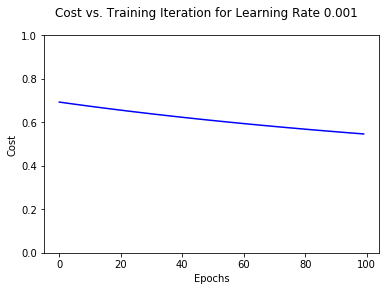

train accuracy: 92.96703296703296 %
test accuracy: 96.49122807017544 %


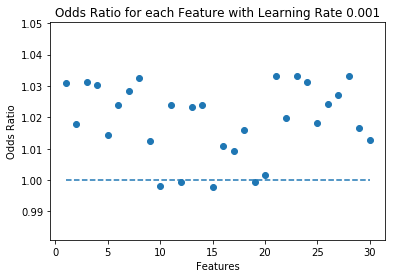

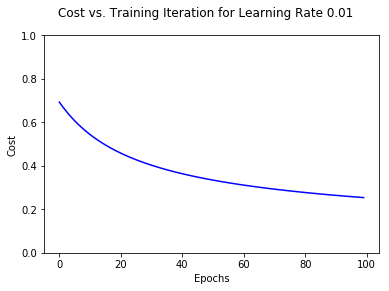

train accuracy: 95.38461538461539 %
test accuracy: 98.24561403508773 %


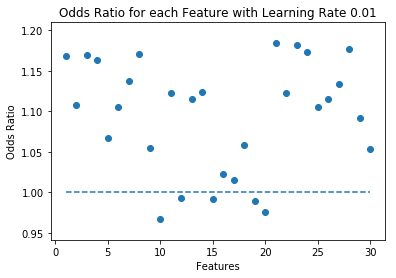

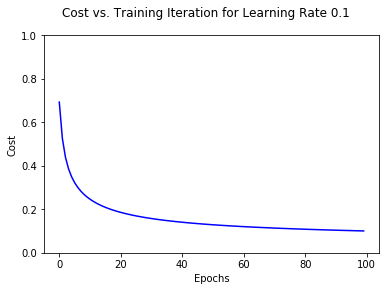

train accuracy: 98.24175824175825 %
test accuracy: 98.24561403508773 %


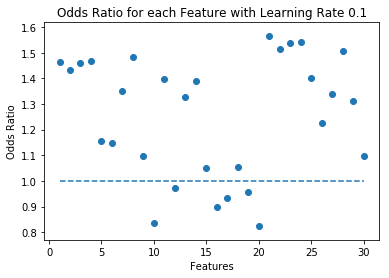

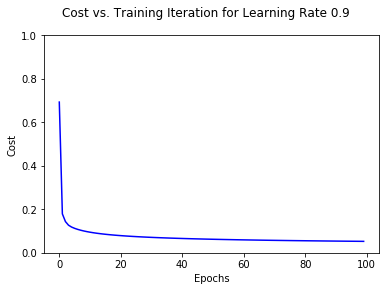

train accuracy: 99.12087912087912 %
test accuracy: 97.36842105263158 %


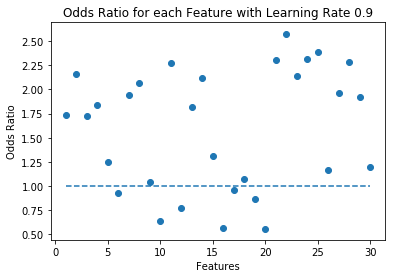

In [16]:
learning_rates = [0.001, 0.01, 0.1, 0.9]
for learning_rate in learning_rates:
    summary = model(X_training, Y_training, X_testing, Y_testing, num_epochs=100, learning_rate=learning_rate)
    
    # These indicate how much each feature contributes to class 1 or 0.
    # Values above 1 indicate the feature is indicative of class 1.
    # Values below 1 indicate the feature is indicative of class 0.
    beta = np.exp(summary['weights'])
    
    # Plotting
    x = np.linspace(1, 30, 30)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.ion()
    plt.title('Odds Ratio for each Feature with Learning Rate {}'.format(learning_rate))
    fig.show()
    fig.canvas.draw()
    plt.scatter(x, beta.flatten())
    plt.plot(x, np.ones((30)), '--')
    plt.xlabel('Features')
    plt.ylabel('Odds Ratio')
    plt.show()

There's a few interesting trends here. Increasing the learning rate tends to improve performance on the training set, but a very large learning rate actually reduces performance on the test set. This presents a classic trade-off in machine learning applications, and is why hyperparameter tuning is so important.

Also, the algorithm has learned which features are more indicative of which class! Things get a little more complicated when we start using more complex models, but this is a good place to gain some understanding of how machine learning algorithms work.